In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob

import tensorflow as tf
from tensorflow.math import confusion_matrix
from tensorflow.keras.losses import BinaryCrossentropy

from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, TextVectorization, Input, Dense, LSTM, Bidirectional, Dropout, concatenate
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Transformation der Daten in CSV

In [ ]:
spam_folder = "spam/"
ham_folder = "ham/"

data_with_meta = []

spam_emails = glob.glob(spam_folder + "*")
ham_emails = glob.glob(ham_folder + "*")

print(len(spam_emails), len(ham_emails))

In [ ]:
for email in spam_emails:
    with open(email, "r", errors="ignore") as f:
        content = f.read()
        content = content.split("\n\n", maxsplit=1)

        meta, text = content
        data_with_meta += [(meta, text, False)]

for email in ham_emails:
    with open(email, "r", errors="ignore") as f:
        content = f.read()
        meta, text = content.split("\n\n", maxsplit=1)
        data_with_meta += [(meta, text, True)]

In [ ]:
df = pd.DataFrame(data_with_meta, columns=["metadata", "content", "spam"])
df.head(5)

In [ ]:
df.to_csv("emails_mit_Metadaten.csv")

## Laden der Daten (mit Metainformationen)

In [2]:
data = pd.read_csv("emails_mit_Metadaten.csv")

In [6]:
X = data[["metadata", "content"]]
y = data["spam"]

<AxesSubplot:ylabel='spam'>

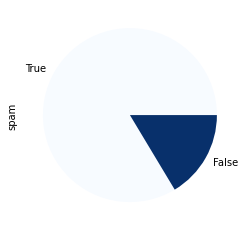

In [7]:
y.value_counts().plot(kind="pie", colormap="Blues")

In [8]:
data.sample(5)

,Unnamed: 0,metadata,content,spam
764,764,From ilug-admin@linux.ie Wed Aug 28 10:49:27 ...,"Hello folks!\nI'm new to Linux, so here goes.....",True
1216,1216,From fork-admin@xent.com Fri Sep 20 11:32:32 ...,"> On Thu, 19 Sep 2002, Bill Stoddard wrote:\n>...",True
1381,1381,From fork-admin@xent.com Mon Sep 30 19:58:59 ...,"On Mon, 2002-09-30 at 09:20, Owen Byrne wrote:...",True
1727,1727,From exmh-workers-admin@redhat.com Wed Oct 2...,\nI apologize for not catching up to the curre...,True
112,112,From 2940catv77@alltel.net Tue Aug 27 01:34:0...,Legal TV Descarmbler\n\nWant to watch Sporting...,False


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

In [20]:
X_train.sample(5)

,metadata,content
323,From wclimenh@megamail.pt Mon Sep 16 13:07:44...,<html><head><title>::FREE MORTGAGE QUOTE::</ti...
92,From tawneemail@yahoo.com Mon Aug 26 15:49:20...,<TABLE borderColorDark=#0000cc width=700 align...
752,From ilug-admin@linux.ie Wed Aug 28 10:48:11 ...,"On Tue, 27 Aug 2002, David Neary wrote:\n\n> >..."
2538,From rssfeeds@jmason.org Thu Sep 26 16:33:57 ...,URL: http://boingboing.net/#85494694\nDate: No...
24,From iq@insurancemail.net Fri Aug 23 11:17:41...,This is a multi-part message in MIME format.\n...


## Erstellung des RNN (mit Metadaten)

In [40]:
max_tokens = 10000
sequence_len = 256

meta_vector_layer = TextVectorization(max_tokens=max_tokens, output_sequence_length=sequence_len)
meta_vector_layer.adapt(X_train["metadata"])

text_vector_layer = TextVectorization(max_tokens=max_tokens, output_sequence_length=sequence_len)
text_vector_layer.adapt(X_train["content"])

In [41]:
# Defintion of input layers
meta_input = Input(dtype=tf.string, shape=1, name="metadata_input")
text_input = Input(dtype=tf.string, shape=1, name="content_input")

# Definition of layers for meta data
branch1 = meta_vector_layer(meta_input)
branch1 = Embedding(input_dim=meta_vector_layer.vocabulary_size(), output_dim=256, mask_zero=True)(branch1)
branch1 = Bidirectional(LSTM(128, return_sequences=True))(branch1)
branch1 = Dropout(0.03)(branch1)
branch1 = Bidirectional(LSTM(64, return_sequences=True))(branch1)
branch1 = Dropout(0.002)(branch1)
branch1 = LSTM(32)(branch1)

# Definition of layers for email content
branch2 = text_vector_layer(text_input)
branch2 = Embedding(input_dim=text_vector_layer.vocabulary_size(), output_dim=256, mask_zero=True)(branch2)
branch2 = Bidirectional(LSTM(128, return_sequences=True))(branch2)
branch2 = Dropout(0.03)(branch2)
branch2 = Bidirectional(LSTM(64, return_sequences=True))(branch2)
branch2 = Dropout(0.002)(branch2)
branch2 = LSTM(32)(branch2)

# Merge layers and define output
layers = concatenate([branch1, branch2], name="concatenated_layers")
# layers = Dense(128, activation="relu", name="dense_csv_img")(layers)
output = Dense(1, activation="sigmoid")(layers)

model = Model(inputs=[meta_input, text_input], outputs=output)
model.compile(optimizer="adam", loss=BinaryCrossentropy(), metrics=["accuracy"])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 metadata_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 content_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_4 (TextVect  (None, 256)         0           ['metadata_input[0][0]']         
 orization)                                                                                       
                                                                                                  
 text_vectorization_5 (TextVect  (None, 256)         0           ['content_input[0][0]']    

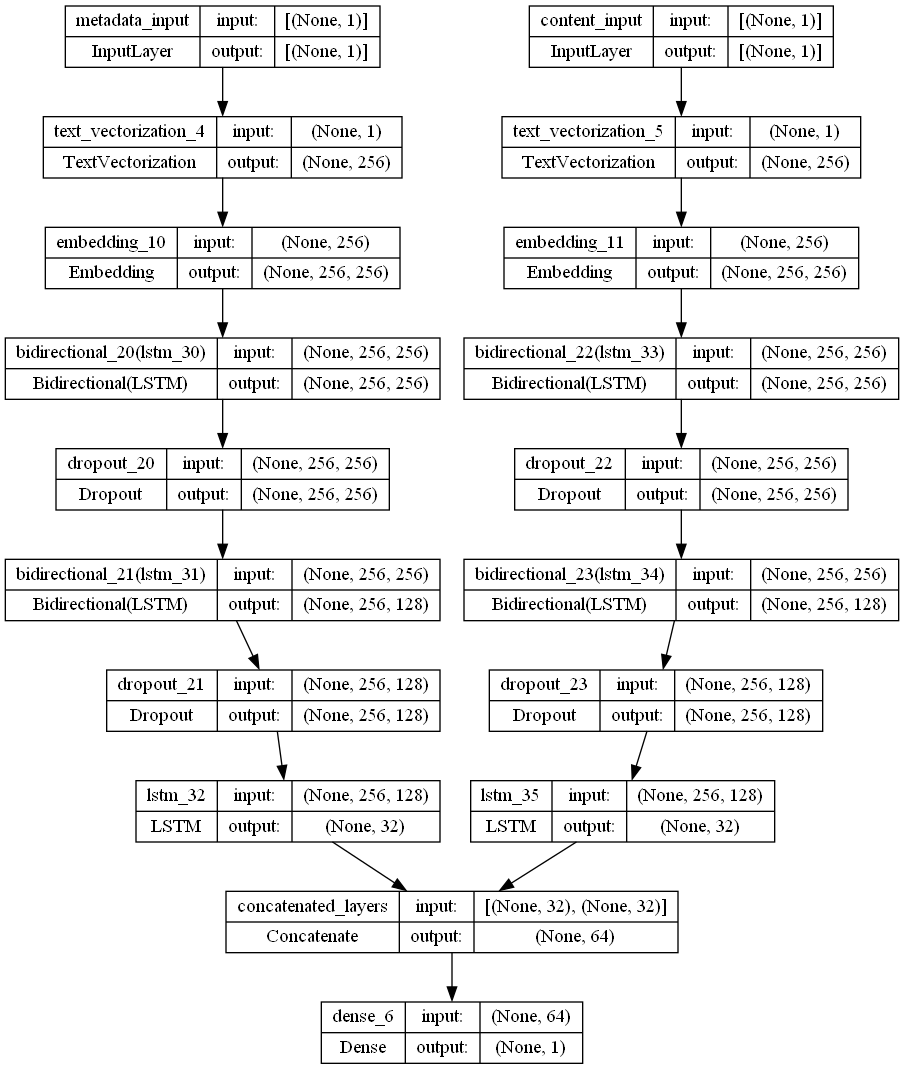

In [42]:
plot_model(model, to_file="model_rnn_meta_plot.png", show_shapes=True, show_layer_names=True)

In [43]:
history = model.fit([X_train["metadata"], X_train["content"]], y_train, epochs=3, validation_split=0.15)

Epoch 1/3
57/57 [==============================] - 413s 7s/step - loss: 0.1845 - accuracy: 0.9289 - val_loss: 0.0514 - val_accuracy: 0.9813
Epoch 2/3
57/57 [==============================] - 378s 7s/step - loss: 0.0210 - accuracy: 0.9939 - val_loss: 0.0288 - val_accuracy: 0.9969
Epoch 3/3
57/57 [==============================] - 379s 7s/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0173 - val_accuracy: 0.9938


In [45]:
model.save("rnn_model_meta.tf")

INFO:tensorflow:Assets written to: rnn_model_meta.tf\assets


INFO:tensorflow:Assets written to: rnn_model_meta.tf\assets


## Evaluierung

In [44]:
accuracy = model.evaluate([X_test["metadata"], X_test["content"]], y_test, verbose=0)
print("test loss, test accuracy:", accuracy)

test loss, test accuracy: [0.025932006537914276, 0.9912663698196411]


In [46]:
y_pred = model.predict([X_test["metadata"], X_test["content"]])
y_pred_bin = np.round(y_pred)

confusion = confusion_matrix(labels=y_test, predictions=y_pred_bin)

29/29 [==============================] - 95s 3s/step


Text(0, 0.5, 'Anzahl der vorhergesagten Werte')

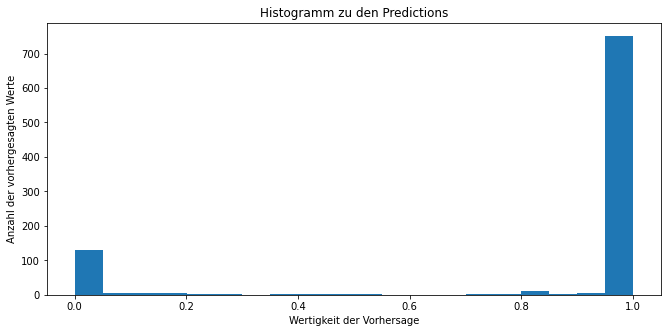

In [47]:
plt.figure(figsize=(11,5))
plt.hist(y_pred, bins=20)
plt.title("Histogramm zu den Predictions")

plt.xlabel("Wertigkeit der Vorhersage")
plt.ylabel("Anzahl der vorhergesagten Werte")

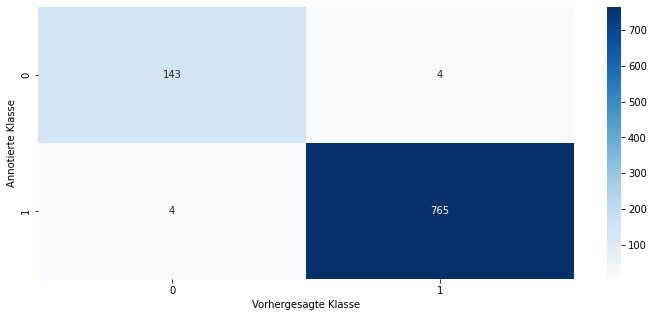

In [48]:
plt.figure(figsize=(12,5))
sns.heatmap(confusion, annot=True, fmt="d", cmap=plt.cm.Blues)

plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Annotierte Klasse")
plt.show()

## Vergleich zu Modell ohne Metadaten

In [50]:
model_without_meta = Sequential([
    Input(dtype=tf.string, shape=1, name="content_input"),
    text_vector_layer,
    Embedding(input_dim=text_vector_layer.vocabulary_size(), output_dim=256, mask_zero=True),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.03),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.002),
    LSTM(32),
    Dense(1, activation="sigmoid"),
])

model_without_meta.compile(optimizer="adam", loss=BinaryCrossentropy(), metrics=["accuracy"])
model_without_meta.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (TextV  (None, 256)              0         
 ectorization)                                                   
                                                                 
 embedding_12 (Embedding)    (None, 256, 256)          2560000   
                                                                 
 bidirectional_24 (Bidirecti  (None, 256, 256)         394240    
 onal)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 256, 256)          0         
                                                                 
 bidirectional_25 (Bidirecti  (None, 256, 128)         164352    
 onal)                                                           
                                                      

In [51]:
history = model_without_meta.fit(X_train["content"], y_train, epochs=3, validation_split=0.15)

Epoch 1/3
57/57 [==============================] - 411s 7s/step - loss: 0.2937 - accuracy: 0.9013 - val_loss: 0.1289 - val_accuracy: 0.9502
Epoch 2/3
57/57 [==============================] - 380s 7s/step - loss: 0.0470 - accuracy: 0.9890 - val_loss: 0.1749 - val_accuracy: 0.9533
Epoch 3/3
57/57 [==============================] - 386s 7s/step - loss: 0.0322 - accuracy: 0.9939 - val_loss: 0.0310 - val_accuracy: 0.9907


In [53]:
accuracy = model_without_meta.evaluate(X_test["content"], y_test, verbose=0)
print("test loss, test accuracy:", accuracy)

test loss, test accuracy: [0.06331804394721985, 0.9836244583129883]


## Konklusion

Die Ergebnisse zwischen einem RNN-Modell mit bzw. ohne Berücksichtigung der Metadaten sind relativ ähnlich. In beiden Fällen kann mit einer Accuracy von circa 99% ein gutes Ergebnis erzielt werden, wenngleich fraglich ist, ob dieses auch in der Realität so ausfallen würde.

| Modell | Daten | Accuracy |
| --- | --- | --- |
| RNN mit Metadaten | Training | 0.994 |
| RNN mit Metadaten | Testing | 0.991 |
| RNN ohne Metadaten | Training | 0.991 |
| RNN ohne Metadaten | Testing | 0.984 |

Es kann gefolgert werden, dass die Metadaten zur Klassifikation von Spam nur einen geringen Einfluss haben, dennoch die Performance von Modellen positiv beeinflussen können.